### Открытый курс по машинному обучению
Автор материала: Ольга Дайховская (@aiho в Slack ODS)
Материал распространяется на условиях лицензии Creative Commons CC BY-NC-SA 4.0. Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('howpop_train.csv')
test_df  = pd.read_csv('howpop_test.csv')

In [3]:
train_df.head(1).T

,0
Unnamed: 0.1,0
Unnamed: 0,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305


In [4]:
train_df.shape, test_df.shape

((9000, 19), (3990, 9))

Убедимся, что данные отсортированы по признаку published

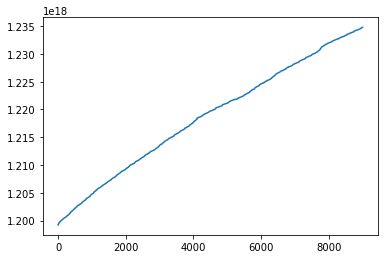

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

Вопрос 1. Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)

In [6]:
train_df.corr()

,Unnamed: 0.1,Unnamed: 0,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
Unnamed: 0.1,1.000000,1.000000,0.299345,-0.032035,0.106507,0.030167,0.072412,0.065755,0.192106,0.160820,0.004699,-0.000998,-0.016781
Unnamed: 0,1.000000,1.000000,0.299345,-0.032035,0.106507,0.030167,0.072412,0.065755,0.192106,0.160820,0.004699,-0.000998,-0.016781
post_id,0.299345,0.299345,1.000000,0.019900,0.032335,0.001124,0.009688,0.015441,0.050545,0.038571,-0.025664,-0.029586,-0.029689
polling,-0.032035,-0.032035,0.019900,1.000000,-0.093842,-0.010708,-0.046183,-0.020961,-0.055845,0.053098,-0.054391,-0.126452,-0.004415
content_len,0.106507,0.106507,0.032335,-0.093842,1.000000,0.088366,0.391484,0.231657,0.184535,-0.022960,0.389368,0.439304,0.135812
comments,0.030167,0.030167,0.001124,-0.010708,0.088366,1.000000,0.164933,0.087876,0.629167,0.425881,0.222542,0.307559,0.717167
favs,0.072412,0.072412,0.009688,-0.046183,0.391484,0.164933,1.000000,0.669598,0.368494,0.004768,0.497312,0.590705,0.226634
views,0.065755,0.065755,0.015441,-0.020961,0.231657,0.087876,0.669598,1.000000,0.159029,0.004752,0.493085,0.326643,0.121134
votes_plus,0.192106,0.192106,0.050545,-0.055845,0.184535,0.629167,0.368494,0.159029,1.000000,0.521751,0.281420,0.467468,0.607186
votes_minus,0.160820,0.160820,0.038571,0.053098,-0.022960,0.425881,0.004768,0.004752,0.521751,1.000000,0.020213,0.039133,0.368753


In [7]:
[abs(i) for i in np.array(train_df.corr()).flatten() 
 if (i > 0.9) & (i < 1)]

[]

ответ: нет

В каком году было больше всего публикаций? (Рассматриваем train_df)

In [8]:
train_df.published.apply(lambda ts: pd.to_datetime(ts).year).value_counts()

2008    7743
2009    1257
Name: published, dtype: int64

### Разбиение на train/valid

Используем только признаки 'author', 'flow', 'domain' и 'title'

In [9]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [10]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [11]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

### TfidfVectorizer

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для **оценки важности слова в контексте документа**, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции.

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

Основные параметры TfidfVectorizer в sklearn:

* min_df - при построении словаря слова, которые встречаются реже, чем указанное значение, игнорируются
* max_df - при построении словаря слова, которые встречаются чаще, чем указанное значение, игнорируются
* analyzer - определяет, строятся ли признаки по словам или по символам (буквам)
* ngram_range - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
* stop_words - слова, которые игнорируются при построении матрицы

Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']

In [12]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, 
                                   ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])

X_valid_title = vectorizer_title.transform(X_valid['title'])

X_test_title = vectorizer_title.transform(X_test['title'])

In [13]:
X_train_title.shape

(6300, 2831)

In [14]:
#Можно посмотреть словарь в виде {'термин': индекс признака,...}
vectorizer_title.vocabulary_

{'подарок': 1961,
 'wordpress': 707,
 'яйца': 2823,
 'или': 1261,
 'сервис': 2370,
 'для': 1076,
 'отслеживания': 1851,
 'посетителей': 2049,
 'или сервис': 1267,
 'сервис для': 2371,
 'для отслеживания': 1107,
 'или сервис для': 1268,
 'шрифтов': 2782,
 'почему': 2058,
 'мне': 1549,
 'не': 1685,
 'iphone': 338,
 'мне не': 1550,
 'действии': 1040,
 'чем': 2758,
 'проекта': 2156,
 'ru': 558,
 'search': 568,
 'понедельник': 2038,
 'mobile': 408,
 'выбор': 969,
 'способа': 2482,
 'связи': 2344,
 'обзор': 1749,
 'под': 1956,
 'windows': 697,
 'под windows': 1959,
 'онлайн': 1788,
 'оформление': 1863,
 'новые': 1726,
 'скриншоты': 2408,
 'ос': 1808,
 'кто': 1455,
 'должен': 1137,
 'писать': 1917,
 'js': 359,
 'код': 1394,
 'процессе': 2178,
 'работы': 2207,
 'над': 1650,
 'top': 637,
 '10': 3,
 'стартапов': 2514,
 'на': 1596,
 'которые': 1441,
 'стоит': 2533,
 'внимание': 915,
 '2008': 27,
 'году': 1008,
 'стартапов на': 2515,
 '2008 году': 32,
 'википедии': 903,
 'мини': 1539,
 'хочу': 273

Какой индекс у слова 'python'?

In [15]:
vectorizer_title.vocabulary_['python']

524

Инициализируйте TfidfVectorizer, указав analyzer='char'.
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']

Какой размер у полученного словаря?

In [16]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [17]:
X_train_title_ch.shape

(6300, 131)

In [18]:
#Здесь так же можно посмотреть словарь
#Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

{'н': 94,
 'о': 95,
 'в': 83,
 'г': 84,
 'д': 85,
 'и': 89,
 'й': 90,
 ' ': 0,
 'п': 96,
 'а': 81,
 'р': 97,
 'к': 91,
 'б': 82,
 'л': 92,
 'е': 86,
 'м': 93,
 '—': 118,
 'w': 61,
 'o': 53,
 'r': 56,
 'd': 42,
 'p': 54,
 'e': 43,
 's': 57,
 '2': 18,
 '.': 14,
 '3': 19,
 'с': 98,
 'у': 100,
 'ш': 105,
 'я': 112,
 'ц': 103,
 ',': 12,
 'т': 99,
 'ж': 87,
 'ф': 101,
 'ь': 109,
 'ч': 104,
 'i': 47,
 'h': 46,
 'n': 52,
 'm': 51,
 'b': 40,
 'l': 50,
 '0': 16,
 'щ': 106,
 'k': 49,
 'v': 60,
 'a': 39,
 'u': 59,
 ':': 26,
 'c': 41,
 'з': 88,
 'ы': 108,
 '«': 74,
 '»': 78,
 'х': 102,
 'j': 48,
 '?': 31,
 't': 58,
 '-': 13,
 '1': 17,
 '8': 24,
 '!': 1,
 '9': 25,
 '5': 21,
 '7': 23,
 'q': 55,
 'y': 63,
 'x': 62,
 'g': 45,
 'ю': 111,
 'ъ': 107,
 '4': 20,
 '=': 29,
 '(': 8,
 ')': 9,
 '+': 11,
 'f': 44,
 '…': 122,
 'э': 110,
 '6': 22,
 'z': 64,
 '/': 15,
 '$': 4,
 'ё': 113,
 "'": 7,
 '№': 125,
 '–': 117,
 '[': 33,
 ']': 35,
 '_': 37,
 '\xa0': 71,
 '*': 10,
 '%': 5,
 '{': 65,
 '}': 67,
 '’': 119,
 '|':

### Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать **DictVectorizer** из sklearn.

In [19]:
feats = ['author', 'flow', 'domain']
X_train[feats]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru
...,...,...,...
6295,@dinamyte,develop,habrahabr.ru
6296,@mdevils,misc,habrahabr.ru
6297,@art_lomov,misc,habrahabr.ru
6298,@keysolutions,develop,habrahabr.ru


In [20]:
#сначала заполняем пропуски прочерком
X_train[feats].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru
...,...,...,...
6295,@dinamyte,develop,habrahabr.ru
6296,@mdevils,misc,habrahabr.ru
6297,@art_lomov,misc,habrahabr.ru
6298,@keysolutions,develop,habrahabr.ru


In [21]:
#Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
#а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [22]:
#В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
#поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [23]:
#В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

Но можно преобразовать ее в numpy array с помощью .toarray()


In [24]:
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [25]:
#В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
#Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [26]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [27]:
#например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

Инициализируйте DictVectorizer с параметрами по умолчанию.
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']

In [28]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train.loc[:, feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid.loc[:, feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test.loc[:, feats].fillna('-').T.to_dict().values())

In [29]:
X_train_feats.shape

(6300, 1821)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [30]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией

Основной параметр Ridge - alpha, коэффициент регуляризации. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1

Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.

In [31]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)

CPU times: total: 297 ms
Wall time: 560 ms


Ridge(alpha=0.1, random_state=1)

In [49]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

In [32]:
%%time
model2 = Ridge(alpha=1.0,random_state=1)
model2.fit(X_train_new, y_train)

CPU times: total: 188 ms
Wall time: 128 ms


Ridge(random_state=1)

In [33]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

* при alpha=0.1 модель переобучается
* при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

## Baseline

Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.

In [34]:
%%time

model = Ridge()
#обучаем на всех данных
model.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y) 
test_preds = model.predict(X_test_new)

CPU times: total: 250 ms
Wall time: 172 ms
